In [1]:
!sudo apt-get update
!sudo apt-get install openmpi-bin openmpi-common libopenmpi-dev -y

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,816 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,368 kB]
Get:14 http://se

In [60]:
%%writefile mpi_hello_world.c
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>

int main(int argc, char** argv) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int n;
    if (rank == 0) {
        if (argc > 1) {
            n = atoi(argv[1]);
        } else {
            n = 1000;
        }
    }

    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);

    int base = n / size;
    int resto = n % size;
    int linhas_local = base + (rank < resto ? 1 : 0);

    int *sendcounts = NULL, *displs = NULL;
    if (rank == 0) {
        sendcounts = malloc(size * sizeof(int));
        displs = malloc(size * sizeof(int));
        int offset = 0;
        for (int i = 0; i < size; i++) {
            int linhas = base + (i < resto ? 1 : 0);
            sendcounts[i] = linhas * n;
            displs[i] = offset;
            offset += sendcounts[i];
        }
    }

    double *A = NULL, *B = NULL, *C = NULL;
    double *subA = malloc(linhas_local * n * sizeof(double));
    double *subB = malloc(linhas_local * n * sizeof(double));
    double *subC = malloc(linhas_local * n * sizeof(double));

    if (rank == 0) {
        A = malloc(n * n * sizeof(double));
        B = malloc(n * n * sizeof(double));
        C = malloc(n * n * sizeof(double));
        for (int i = 0; i < n * n; i++) {
            A[i] = rand() % 10;
            B[i] = rand() % 10;
        }
    }

    MPI_Barrier(MPI_COMM_WORLD);
    double start = MPI_Wtime();

    MPI_Scatterv(A, sendcounts, displs, MPI_DOUBLE,
                 subA, linhas_local * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Scatterv(B, sendcounts, displs, MPI_DOUBLE,
                 subB, linhas_local * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    for (int i = 0; i < linhas_local * n; i++)
        subC[i] = subA[i] + subB[i];

    MPI_Gatherv(subC, linhas_local * n, MPI_DOUBLE,
                C, sendcounts, displs, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    MPI_Barrier(MPI_COMM_WORLD);
    double end = MPI_Wtime();

    if (rank == 0) {
        printf("Tempo total (soma): %.6f segundos\n", end - start);
        free(A); free(B); free(C); free(sendcounts); free(displs);
    }

    free(subA); free(subB); free(subC);
    MPI_Finalize();
    return 0;
}

Overwriting mpi_hello_world.c


In [26]:
!mpicc mpi_hello_world.c -o mpi_hello_world_arg
!ls -l mpi_hello_world_arg

-rwxr-xr-x 1 root root 16632 Oct 15 17:57 mpi_hello_world_arg


In [61]:
%%writefile maior_valor.c
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>

int main(int argc, char** argv) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int n;
    if (rank == 0) {
        if (argc > 1) {
            n = atoi(argv[1]);
        } else {
            n = 1000;
        }
    }

    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);

    int base = n / size;
    int resto = n % size;
    int linhas_local = base + (rank < resto ? 1 : 0);

    int *sendcounts = NULL, *displs = NULL;
    if (rank == 0) {
        sendcounts = malloc(size * sizeof(int));
        displs = malloc(size * sizeof(int));
        int offset = 0;
        for (int i = 0; i < size; i++) {
            int linhas = base + (i < resto ? 1 : 0);
            sendcounts[i] = linhas * n;
            displs[i] = offset;
            offset += sendcounts[i];
        }
    }

    double *A = NULL, *B = NULL, *C = NULL;
    double *subA = malloc(linhas_local * n * sizeof(double));
    double *subB = malloc(linhas_local * n * sizeof(double));
    double *subC = malloc(linhas_local * n * sizeof(double));

    if (rank == 0) {
        A = malloc(n * n * sizeof(double));
        B = malloc(n * n * sizeof(double));
        C = malloc(n * n * sizeof(double));
        for (int i = 0; i < n * n; i++) {
            A[i] = rand() % 10;
            B[i] = rand() % 10;
        }
    }

    MPI_Barrier(MPI_COMM_WORLD);
    double start = MPI_Wtime();

    MPI_Scatterv(A, sendcounts, displs, MPI_DOUBLE,
                 subA, linhas_local * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    MPI_Scatterv(B, sendcounts, displs, MPI_DOUBLE,
                 subB, linhas_local * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    for (int i = 0; i < linhas_local * n; i++)
        subC[i] = subA[i] + subB[i];

    MPI_Gatherv(subC, linhas_local * n, MPI_DOUBLE,
                C, sendcounts, displs, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    MPI_Barrier(MPI_COMM_WORLD);
    double end = MPI_Wtime();

    if (rank == 0) {
        printf("Tempo total (soma): %.6f segundos\n", end - start);
        free(A); free(B); free(C); free(sendcounts); free(displs);
    }

    free(subA); free(subB); free(subC);
    MPI_Finalize();
    return 0;
}

Overwriting maior_valor.c


In [28]:
!mpicc maior_valor.c -o maior_valor_arg
!ls -l maior_valor_arg

-rwxr-xr-x 1 root root 16632 Oct 15 17:57 maior_valor_arg


In [62]:
%%writefile vetor_matriz.c
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>

int main(int argc, char** argv) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int n;
    if (rank == 0) {
        if (argc > 1) {
            n = atoi(argv[1]);
        } else {
            n = 1000;
        }
    }

    MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);

    int base = n / size;
    int resto = n % size;
    int linhas_local = base + (rank < resto ? 1 : 0);

    int *sendcounts = NULL, *displs = NULL;
    if (rank == 0) {
        sendcounts = malloc(size * sizeof(int));
        displs = malloc(size * sizeof(int));
        int offset = 0;
        for (int i = 0; i < size; i++) {
            int linhas = base + (i < resto ? 1 : 0);
            sendcounts[i] = linhas * n;
            displs[i] = offset;
            offset += sendcounts[i];
        }
    }

    double *A = NULL, *v = NULL, *r = NULL;
    double *subA = malloc(linhas_local * n * sizeof(double));
    double *subR = malloc(linhas_local * sizeof(double));

    if (rank == 0) {
        A = malloc(n * n * sizeof(double));
        v = malloc(n * sizeof(double));
        r = malloc(n * sizeof(double));
        for (int i = 0; i < n * n; i++) A[i] = rand() % 10;
        for (int i = 0; i < n; i++) v[i] = rand() % 10;
    } else {
        v = malloc(n * sizeof(double));
    }

    MPI_Bcast(v, n, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    MPI_Barrier(MPI_COMM_WORLD);
    double start = MPI_Wtime();

    MPI_Scatterv(A, sendcounts, displs, MPI_DOUBLE,
                 subA, linhas_local * n, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    for (int i = 0; i < linhas_local; i++) {
        subR[i] = 0;
        for (int j = 0; j < n; j++)
            subR[i] += subA[i * n + j] * v[j];
    }

    int *recvcounts = NULL, *recvdispls = NULL;
    if (rank == 0) {
        recvcounts = malloc(size * sizeof(int));
        recvdispls = malloc(size * sizeof(int));
        int offset = 0;
        for (int i = 0; i < size; i++) {
            int linhas = base + (i < resto ? 1 : 0);
            recvcounts[i] = linhas;
            recvdispls[i] = offset;
            offset += linhas;
        }
    }

    MPI_Gatherv(subR, linhas_local, MPI_DOUBLE,
                r, recvcounts, recvdispls, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    MPI_Barrier(MPI_COMM_WORLD);
    double end = MPI_Wtime();

    if (rank == 0) {
        printf("Tempo total (vetor x matriz): %.6f segundos\n", end - start);
        free(A); free(v); free(r);
        free(sendcounts); free(displs);
        free(recvcounts); free(recvdispls);
    } else {
        free(v);
    }

    free(subA); free(subR);
    MPI_Finalize();
    return 0;
}

Overwriting vetor_matriz.c


In [39]:
!mpicc vetor_matriz.c -o vetor_matriz_arg
!ls -l vetor_matriz_arg

-rwxr-xr-x 1 root root 16632 Oct 15 18:35 vetor_matriz_arg


In [47]:
%%writefile run_experiments.sh
#!/bin/bash

ns=(100 1000 10000)
procs=(2 4 6)
executables=("mpi_hello_world_arg" "maior_valor_arg" "vetor_matriz_arg")

echo "Executable,n,processes,time" > results.csv

for exec in "${executables[@]}"; do
  for n_val in "${ns[@]}"; do
    for p_val in "${procs[@]}"; do
      echo "Running $exec with n=$n_val and $p_val processes..."
      output=$(mpirun --allow-run-as-root --oversubscribe -np $p_val ./$exec $n_val)
      time=$(echo "$output" | grep -i "tempo" | grep -Eo "[0-9]+\.[0-9]+")
      echo "$exec,$n_val,$p_val,$time" >> results.csv
    done
  done
done

echo "Experimentation complete. Results saved to results.csv"

Overwriting run_experiments.sh


In [48]:
!chmod +x run_experiments.sh
!./run_experiments.sh

Running mpi_hello_world_arg with n=100 and 2 processes...
Running mpi_hello_world_arg with n=100 and 4 processes...
Running mpi_hello_world_arg with n=100 and 6 processes...
Running mpi_hello_world_arg with n=1000 and 2 processes...
Running mpi_hello_world_arg with n=1000 and 4 processes...
Running mpi_hello_world_arg with n=1000 and 6 processes...
Running mpi_hello_world_arg with n=10000 and 2 processes...
Running mpi_hello_world_arg with n=10000 and 4 processes...
Running mpi_hello_world_arg with n=10000 and 6 processes...
Running maior_valor_arg with n=100 and 2 processes...
Running maior_valor_arg with n=100 and 4 processes...
Running maior_valor_arg with n=100 and 6 processes...
Running maior_valor_arg with n=1000 and 2 processes...
Running maior_valor_arg with n=1000 and 4 processes...
Running maior_valor_arg with n=1000 and 6 processes...
Running maior_valor_arg with n=10000 and 2 processes...
Running maior_valor_arg with n=10000 and 4 processes...
Running maior_valor_arg with n

In [49]:
!cat results.csv

Executable,n,processes,time
mpi_hello_world_arg,100,2,0.000589
mpi_hello_world_arg,100,4,0.001048
mpi_hello_world_arg,100,6,0.000977
mpi_hello_world_arg,1000,2,0.027072
mpi_hello_world_arg,1000,4,0.066592
mpi_hello_world_arg,1000,6,0.060662
mpi_hello_world_arg,10000,2,7.477652
mpi_hello_world_arg,10000,4,16.323567
mpi_hello_world_arg,10000,6,9.055882
maior_valor_arg,100,2,0.000302
maior_valor_arg,100,4,0.001320
maior_valor_arg,100,6,0.002327
maior_valor_arg,1000,2,0.027468
maior_valor_arg,1000,4,0.033825
maior_valor_arg,1000,6,0.053259
maior_valor_arg,10000,2,2.695970
maior_valor_arg,10000,4,5.190562
maior_valor_arg,10000,6,6.632908
vetor_matriz_arg,100,2,0.000147
vetor_matriz_arg,100,4,0.000252
vetor_matriz_arg,100,6,0.000630
vetor_matriz_arg,1000,2,0.012222
vetor_matriz_arg,1000,4,0.030028
vetor_matriz_arg,1000,6,0.036830
vetor_matriz_arg,10000,2,1.190652
vetor_matriz_arg,10000,4,1.785418
vetor_matriz_arg,10000,6,2.172764


In [50]:
import pandas as pd

df = pd.read_csv('results.csv')

display(df.head())
display(df.info())

,Executable,n,processes,time
0,mpi_hello_world_arg,100,2,0.000589
1,mpi_hello_world_arg,100,4,0.001048
2,mpi_hello_world_arg,100,6,0.000977
3,mpi_hello_world_arg,1000,2,0.027072
4,mpi_hello_world_arg,1000,4,0.066592


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Executable  27 non-null     object 
 1   n           27 non-null     int64  
 2   processes   27 non-null     int64  
 3   time        27 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 996.0+ bytes


None

In [51]:
df_n100 = df[df['n'] == 100].pivot(index='processes', columns='Executable', values='time')
df_n1000 = df[df['n'] == 1000].pivot(index='processes', columns='Executable', values='time')
df_n10000 = df[df['n'] == 10000].pivot(index='processes', columns='Executable', values='time')

display(df_n100)
display(df_n1000)
display(df_n10000)

Executable,maior_valor_arg,mpi_hello_world_arg,vetor_matriz_arg
processes,,,
2,0.000302,0.000589,0.000147
4,0.001320,0.001048,0.000252
6,0.002327,0.000977,0.000630


Executable,maior_valor_arg,mpi_hello_world_arg,vetor_matriz_arg
processes,,,
2,0.027468,0.027072,0.012222
4,0.033825,0.066592,0.030028
6,0.053259,0.060662,0.036830


Executable,maior_valor_arg,mpi_hello_world_arg,vetor_matriz_arg
processes,,,
2,2.695970,7.477652,1.190652
4,5.190562,16.323567,1.785418
6,6.632908,9.055882,2.172764


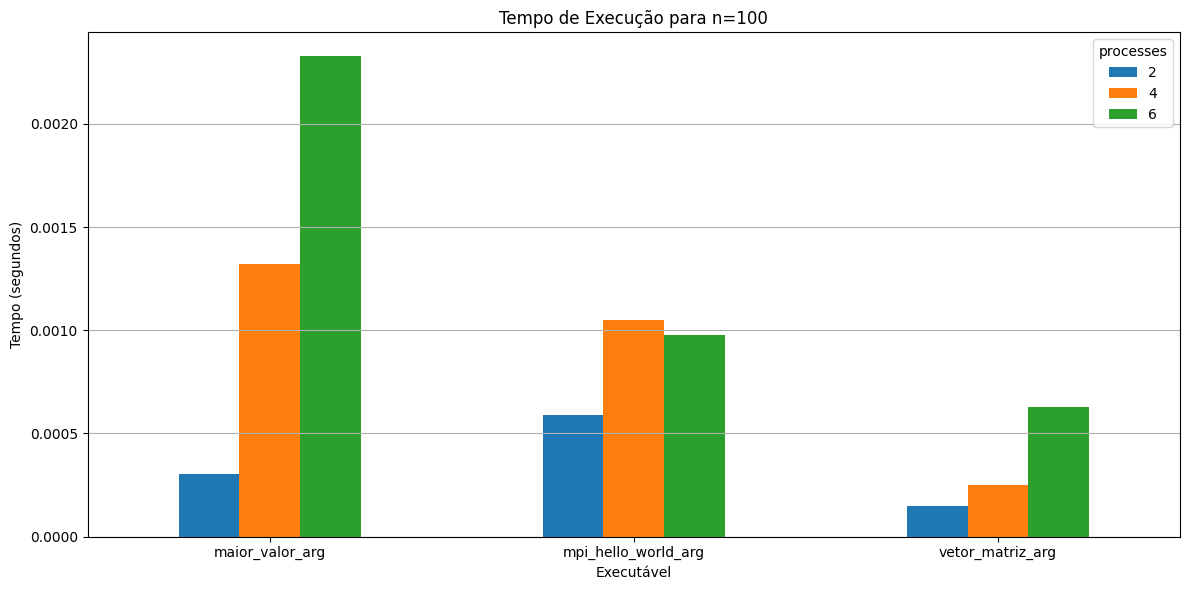

In [59]:
import matplotlib.pyplot as plt


df_n100_pivot = df_n100.T
df_n1000_pivot = df_n1000.T


plt.figure(figsize=(12, 6))
df_n100_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Tempo de Execução para n=100')
plt.xlabel('Executável')
plt.ylabel('Tempo (segundos)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


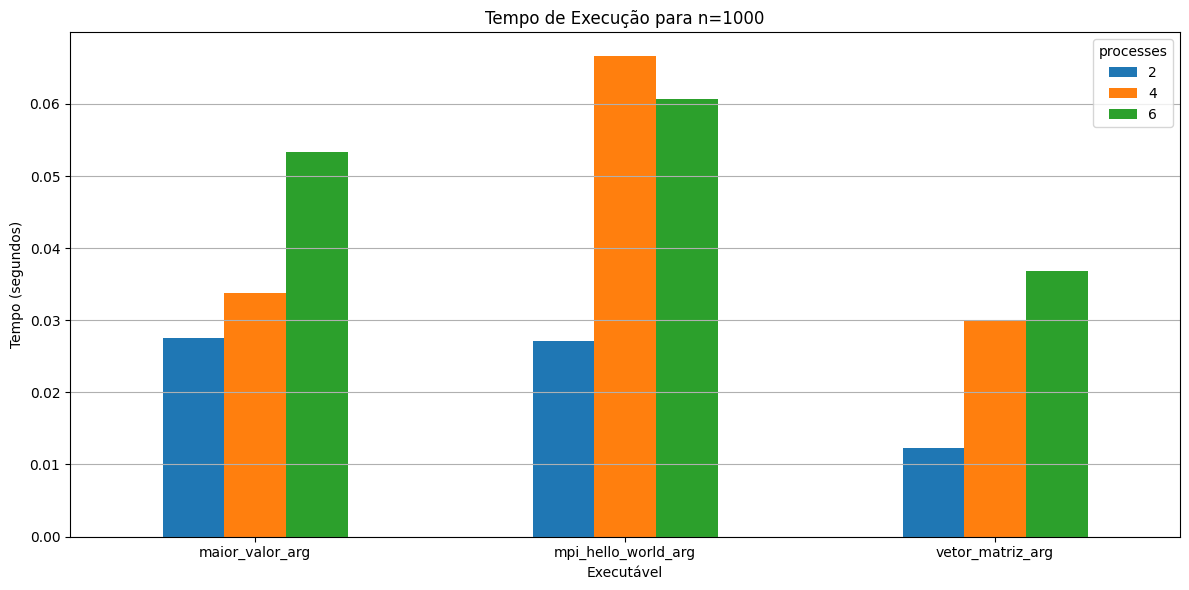

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_n1000_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Tempo de Execução para n=1000')
plt.xlabel('Executável')
plt.ylabel('Tempo (segundos)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

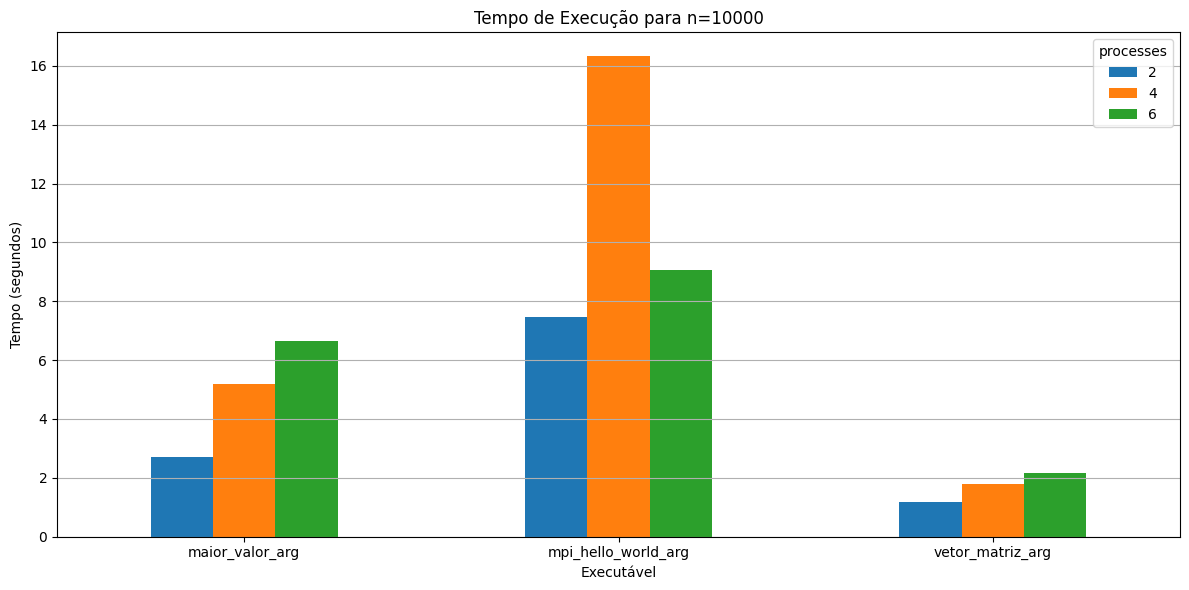

In [57]:
import matplotlib.pyplot as plt

# Pivot the data to have Executable on index and processes as columns
df_n10000_pivot = df_n10000.T


plt.figure(figsize=(12, 6))
df_n10000_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Tempo de Execução para n=10000')
plt.xlabel('Executável')
plt.ylabel('Tempo (segundos)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()